In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

from sklearn.model_selection import StratifiedKFold

from keras.initializers import Constant


nltk.download('omw-1.4')

2023-11-19 16:26:46.007504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/timcrawley/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# import the data (chunksize returns jsonReader for iteration)
businesses = pd.read_json("yelp_academic_dataset_business.json", lines=True, orient='columns', chunksize=200000)
reviews = pd.read_json("yelp_academic_dataset_review.json", lines=True, orient='columns', chunksize=500000)

In [3]:
# read the data
for business in businesses:
    business_chunk = business
    break

for review in reviews:
    review_chunk = review
    break

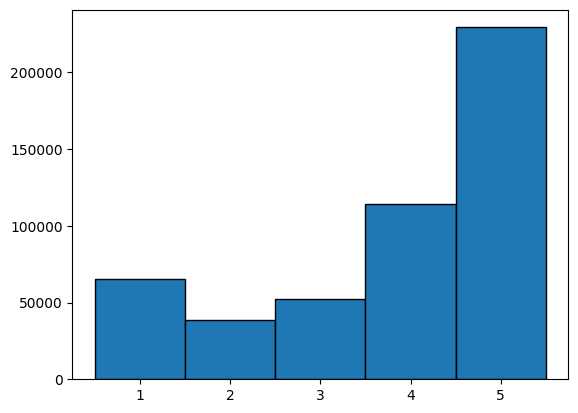

In [4]:
plt.hist(review_chunk['stars'], range=(0.5,5.5), bins=5, edgecolor="black")
plt.show()

In [5]:
# To create a df of reviews of Restaurants
restaurants = business_chunk[business['categories'].str.contains('Restaurant') == True]
df = review_chunk[review_chunk.business_id.isin(restaurants['business_id']) == True]

In [12]:
def clean_and_tokenize(string):
    lem = WordNetLemmatizer()
    return " ".join([lem.lemmatize(word.lower()) for word in word_tokenize(re.sub(r"[^\w\s]", "", string))])

In [10]:
cols_to_drop = ['review_id', 'user_id', 'business_id', 'useful', 'funny', 'cool', 'date']
df_data = df.copy()
df_data.drop(cols_to_drop, axis = 1, inplace = True) 

In [11]:
df_data.head()

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
2,3,Family diner. Had the buffet. Eclectic assortm...
3,5,"Wow! Yummy, different, delicious. Our favo..."
4,4,Cute interior and owner (?) gave us tour of up...
5,1,I am a long term frequent customer of this est...


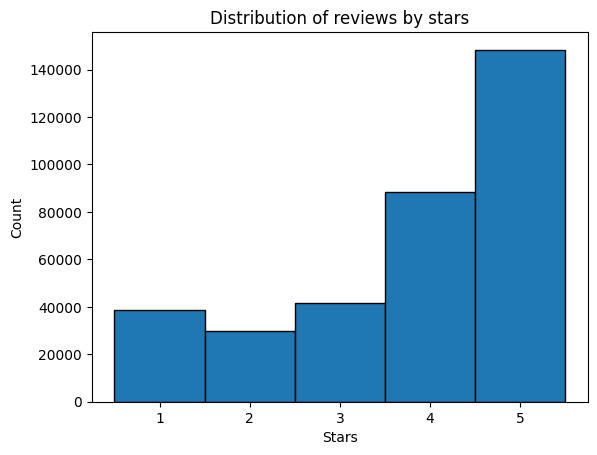

In [91]:
plt.hist(df_data['stars'], range=(0.5,5.5), bins=5, edgecolor="black")
plt.title("Distribution of reviews by stars")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.show()

In [13]:
df_data["lemmatized_text"] = df_data["text"].apply(clean_and_tokenize)

In [14]:
df_data.head()

,stars,text,lemmatized_text
0,3,"If you decide to eat here, just be aware it is...",if you decide to eat here just be aware it is ...
2,3,Family diner. Had the buffet. Eclectic assortm...,family diner had the buffet eclectic assortmen...
3,5,"Wow! Yummy, different, delicious. Our favo...",wow yummy different delicious our favorite is ...
4,4,Cute interior and owner (?) gave us tour of up...,cute interior and owner gave u tour of upcomin...
5,1,I am a long term frequent customer of this est...,i am a long term frequent customer of this est...


In [16]:
# import the glove embeddings
embedding_file = "/Users/timcrawley/Desktop/Fall23/machinelearning/final_project/glove.twitter.27B/glove.twitter.27B.100d.txt"

# read in embeddings
def load_glove_embeddings(embedding_file_path):
    embeddings_index = {}
    with open(embedding_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    file.close()
    return embeddings_index

# Load GloVe embeddings
glove_embeddings = load_glove_embeddings(embedding_file)

In [21]:
# create the tokenizer
tokenizer = Tokenizer(10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_data['lemmatized_text'])

In [22]:
len(tokenizer.word_index) + 1

189750

In [23]:
# sequences
sequences = tokenizer.texts_to_sequences(df_data["lemmatized_text"])

In [24]:
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

In [43]:
d = {"plant": 3, "plants": 4, "excellent": 5, "bad":1}
l = WordNetLemmatizer()
# word = d.pop("good")
# word
for word in list(d.keys()):
    value = d[word]
    d.pop(word)
    lemmed = l.lemmatize(word)
    d[lemmed] = value
    
print(d)

#for list(glove_embeddings.keys())

{'plant': 4, 'excellent': 5, 'bad': 1}


In [33]:
def create_embedding_matrix(embedding_dict, word_index):
    num_words = len(word_index) + 1
    embedding_dim = len(list(embedding_dict.values())[0])
    embedding_matrix = np.zeros((num_words, embedding_dim))
    
    for word, i in word_index.items():
        if i < num_words:
            emb_vec = embedding_dict.get(word)
            if emb_vec is not None:
                embedding_matrix[i] = emb_vec
    
    return embedding_matrix
    

In [34]:
embedding_matrix = create_embedding_matrix(glove_embeddings, tokenizer.word_index)

In [36]:
tokenizer.word_index['great']

31

In [44]:
glove_embeddings['great']

array([ 1.0730e-01,  3.6058e-01,  1.1135e-01, -1.6388e-02,  2.4462e-01,
        3.3248e-01,  1.4966e-01,  2.0867e-03, -4.8247e-01, -7.7983e-01,
       -2.4817e-01, -1.3623e-01, -4.8742e+00, -1.2640e-01,  1.9718e-01,
       -2.3438e-01,  3.1731e-01, -5.3766e-01, -3.3636e-01,  3.2244e-01,
        3.4838e-01,  3.2392e-01,  1.2983e-02, -4.3842e-01, -3.5547e-02,
        4.0794e-01, -2.9037e-01,  2.6939e-01,  2.8962e-01, -6.8695e-01,
       -6.2053e-01,  1.0183e-01, -5.0091e-01,  2.5667e-01,  5.3475e-01,
        5.6865e-01,  7.8983e-01, -3.8752e-01, -4.7427e-01, -4.4889e-01,
       -3.5583e-01, -1.2018e-01, -2.3720e-02,  3.8390e-01,  4.2997e-01,
        3.4273e-01,  2.4447e-02, -1.2669e-01,  2.9001e-01, -1.1947e-02,
       -6.8918e-02, -4.3248e-01, -6.0337e-01, -3.2105e-01,  3.7550e-01,
        3.6800e-01,  1.6839e-01, -3.4344e-01,  2.7393e-01, -3.5549e-01,
        2.3686e-01, -5.3380e-01, -6.9807e-02,  5.2484e-02,  4.4660e-01,
        2.8324e-01, -1.4695e-01, -5.5239e-01, -2.8699e-01,  4.77

In [76]:
embedding_matrix[31]

array([ 1.07299998e-01,  3.60579997e-01,  1.11350000e-01, -1.63880009e-02,
        2.44619995e-01,  3.32480013e-01,  1.49660006e-01,  2.08669994e-03,
       -4.82470006e-01, -7.79829979e-01, -2.48170003e-01, -1.36230007e-01,
       -4.87419987e+00, -1.26399994e-01,  1.97180003e-01, -2.34380007e-01,
        3.17310005e-01, -5.37660003e-01, -3.36360008e-01,  3.22439998e-01,
        3.48379999e-01,  3.23920012e-01,  1.29829999e-02, -4.38419998e-01,
       -3.55469994e-02,  4.07940000e-01, -2.90369987e-01,  2.69389987e-01,
        2.89620012e-01, -6.86950028e-01, -6.20530009e-01,  1.01829998e-01,
       -5.00909984e-01,  2.56669998e-01,  5.34749985e-01,  5.68650007e-01,
        7.89830029e-01, -3.87519985e-01, -4.74269986e-01, -4.48890001e-01,
       -3.55830014e-01, -1.20180003e-01, -2.37199999e-02,  3.83899987e-01,
        4.29969996e-01,  3.42729986e-01,  2.44469997e-02, -1.26690000e-01,
        2.90010005e-01, -1.19470004e-02, -6.89179972e-02, -4.32480007e-01,
       -6.03370011e-01, -

In [45]:
(embedding_matrix[31] == glove_embeddings.get('great')).all()

True

In [47]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, 
                    output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sequence_length,
                    trainable=False))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
# encode the labels
le = LabelEncoder()
df_data['encoded_labels'] = le.fit_transform(df_data['stars'])
df_data[['stars', 'encoded_labels']]

,stars,encoded_labels
0,3,2
2,3,2
3,5,4
4,4,3
5,1,0
...,...,...
499993,4,3
499994,5,4
499997,4,3
499998,2,1


In [49]:
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, df_data['encoded_labels'], test_size=0.1, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [50]:
history = model.fit(X_train, y_train, batch_size=512, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
610/610 [==============================] - 95s 151ms/step - loss: 1.1890 - accuracy: 0.4757 - val_loss: 1.0881 - val_accuracy: 0.5274
Epoch 2/10
610/610 [==============================] - 91s 149ms/step - loss: 1.0773 - accuracy: 0.5275 - val_loss: 1.0548 - val_accuracy: 0.5422
Epoch 3/10
610/610 [==============================] - 80s 132ms/step - loss: 1.0340 - accuracy: 0.5452 - val_loss: 1.0434 - val_accuracy: 0.5572
Epoch 4/10
610/610 [==============================] - 81s 132ms/step - loss: 1.0141 - accuracy: 0.5543 - val_loss: 1.0332 - val_accuracy: 0.5574
Epoch 5/10
610/610 [==============================] - 84s 137ms/step - loss: 0.9882 - accuracy: 0.5657 - val_loss: 1.0307 - val_accuracy: 0.5597
Epoch 6/10
610/610 [==============================] - 91s 149ms/step - loss: 0.9719 - accuracy: 0.5723 - val_loss: 1.0422 - val_accuracy: 0.5579
Epoch 7/10
610/610 [==============================] - 100s 164ms/step - loss: 0.9593 - accuracy: 0.5767 - val_loss: 1.0459 - val_a

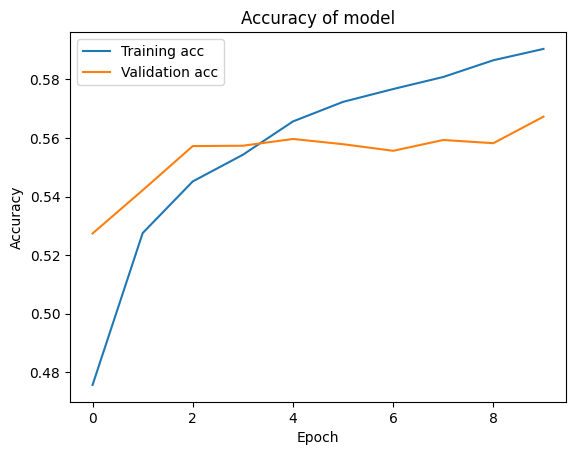

In [51]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [52]:
y_pred = model.predict(X_test)

542/542 [==============================] - 3s 4ms/step


In [56]:
y_pred[0]

array([0.00113817, 0.01269537, 0.1234075 , 0.44653752, 0.4162215 ],
      dtype=float32)

In [72]:
predictions = []
for i in range(len(y_pred)):
    max_value = np.max(y_pred[i])
    index = np.where(y_pred==max_value)
    predictions.append(index[1][0])    

In [63]:
max_value = np.max(y_pred[0])
max_value

0.44653752

In [73]:
predictions[:10]

[3, 4, 4, 4, 4, 1, 4, 4, 0, 3]

In [74]:
accuracy_score(y_test, predictions)

0.5643364313340645

In [75]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.66      0.63      1931
           1       0.32      0.15      0.20      1459
           2       0.31      0.32      0.31      2034
           3       0.44      0.35      0.39      4473
           4       0.68      0.82      0.74      7426

    accuracy                           0.56     17323
   macro avg       0.47      0.46      0.46     17323
weighted avg       0.54      0.56      0.54     17323



In [77]:
from tensorflow.keras.layers import LeakyReLU

model2 = Sequential()
model2.add(Embedding(input_dim=len(tokenizer.word_index)+1, 
                    output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sequence_length,
                    trainable=False))
model2.add(Flatten())
model2.add(Dense(32))
model2.add(LeakyReLU(alpha=0.01))
model2.add(Dropout(0.3))
model2.add(Dense(32))
model2.add(LeakyReLU(alpha=0.01))
model2.add(Dense(5, activation='softmax'))

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [78]:
history2 = model2.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
2437/2437 [==============================] - 121s 48ms/step - loss: 1.1147 - accuracy: 0.5155 - val_loss: 1.0280 - val_accuracy: 0.5567
Epoch 2/10
2437/2437 [==============================] - 148s 61ms/step - loss: 1.0241 - accuracy: 0.5549 - val_loss: 1.0194 - val_accuracy: 0.5603
Epoch 3/10
2437/2437 [==============================] - 131s 54ms/step - loss: 0.9883 - accuracy: 0.5714 - val_loss: 1.0122 - val_accuracy: 0.5581
Epoch 4/10
2437/2437 [==============================] - 114s 47ms/step - loss: 0.9626 - accuracy: 0.5821 - val_loss: 1.0052 - val_accuracy: 0.5716
Epoch 5/10
2437/2437 [==============================] - 113s 46ms/step - loss: 0.9409 - accuracy: 0.5927 - val_loss: 1.0036 - val_accuracy: 0.5679
Epoch 6/10
2437/2437 [==============================] - 110s 45ms/step - loss: 0.9205 - accuracy: 0.6014 - val_loss: 1.0109 - val_accuracy: 0.5690
Epoch 7/10
2437/2437 [==============================] - 113s 46ms/step - loss: 0.9030 - accuracy: 0.6096 - val_loss: 1

In [79]:
# Evaluate the model on the test set
loss, accuracy = model2.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

542/542 [==============================] - 4s 8ms/step - loss: 1.0201 - accuracy: 0.5674
Test Loss: 1.0201, Test Accuracy: 0.5674


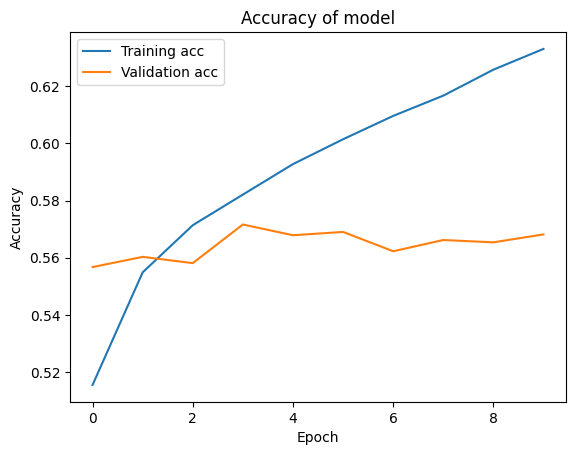

In [80]:
plt.plot(history2.history['accuracy'], label='Training acc')
plt.plot(history2.history['val_accuracy'], label='Validation acc')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [82]:
# third model, will lower batch size
model3 = Sequential()
model3.add(Embedding(input_dim=len(tokenizer.word_index)+1, 
                    output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sequence_length,
                    trainable=False))
model3.add(Flatten())
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dropout(0.3))
model3.add(Dense(5, activation='softmax'))

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1002, 100)         18975000  
                                                                 
 flatten_3 (Flatten)         (None, 100200)            0         
                                                                 
 dense_10 (Dense)            (None, 32)                3206432   
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 5)                

In [83]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [85]:
history3 = model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/10
9745/9745 [==============================] - 239s 24ms/step - loss: 1.1708 - accuracy: 0.4896 - val_loss: 1.0649 - val_accuracy: 0.5363
Epoch 2/10
9745/9745 [==============================] - 227s 23ms/step - loss: 1.0848 - accuracy: 0.5274 - val_loss: 1.0315 - val_accuracy: 0.5519
Epoch 3/10
9745/9745 [==============================] - 244s 25ms/step - loss: 1.0525 - accuracy: 0.5396 - val_loss: 1.0195 - val_accuracy: 0.5516
Epoch 4/10
9745/9745 [==============================] - 259s 27ms/step - loss: 1.0304 - accuracy: 0.5509 - val_loss: 1.0231 - val_accuracy: 0.5515
Epoch 5/10
9745/9745 [==============================] - 239s 24ms/step - loss: 1.0123 - accuracy: 0.5575 - val_loss: 1.0194 - val_accuracy: 0.5649
Epoch 6/10
9745/9745 [==============================] - 227s 23ms/step - loss: 0.9986 - accuracy: 0.5625 - val_loss: 1.0239 - val_accuracy: 0.5592
Epoch 7/10
9745/9745 [==============================] - 232s 24ms/step - loss: 0.9863 - accuracy: 0.5684 - val_loss: 1

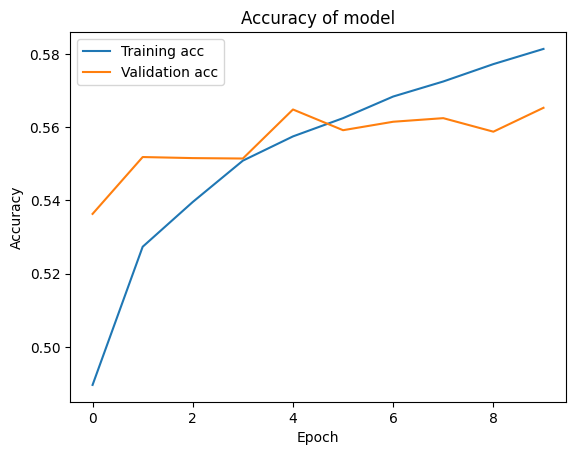

In [86]:
plt.plot(history3.history['accuracy'], label='Training acc')
plt.plot(history3.history['val_accuracy'], label='Validation acc')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [87]:
loss, accuracy = model3.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

542/542 [==============================] - 4s 6ms/step - loss: 1.0152 - accuracy: 0.5637
Test Loss: 1.0152, Test Accuracy: 0.5637


In [88]:
y_pred3 = model3.predict(X_test)
predictions3 = []
for i in range(len(y_pred3)):
    max_value = np.max(y_pred3[i])
    index = np.where(y_pred3==max_value)
    predictions3.append(index[1][0])
    
print(classification_report(y_test, predictions))

542/542 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

           0       0.60      0.66      0.63      1931
           1       0.32      0.15      0.20      1459
           2       0.31      0.32      0.31      2034
           3       0.44      0.35      0.39      4473
           4       0.68      0.82      0.74      7426

    accuracy                           0.56     17323
   macro avg       0.47      0.46      0.46     17323
weighted avg       0.54      0.56      0.54     17323

